In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [6]:
data = r"D:\Brain_tumour_dataset"
No_brain_tumor = r"D:\Brain_tumour_dataset\no"
Yes_brain_tumor = r"D:\Brain_tumour_dataset\yes"

In [7]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  80    labels:  80


In [9]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(80,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,D:\Brain_tumour_dataset\no\1 no.jpeg,No
1,D:\Brain_tumour_dataset\no\10 no.jpg,No
2,D:\Brain_tumour_dataset\no\11 no.jpg,No
3,D:\Brain_tumour_dataset\no\12 no.jpg,No
4,D:\Brain_tumour_dataset\no\13 no.jpg,No


In [10]:
print(df['labels'].value_counts())

Yes    41
No     39
Name: labels, dtype: int64


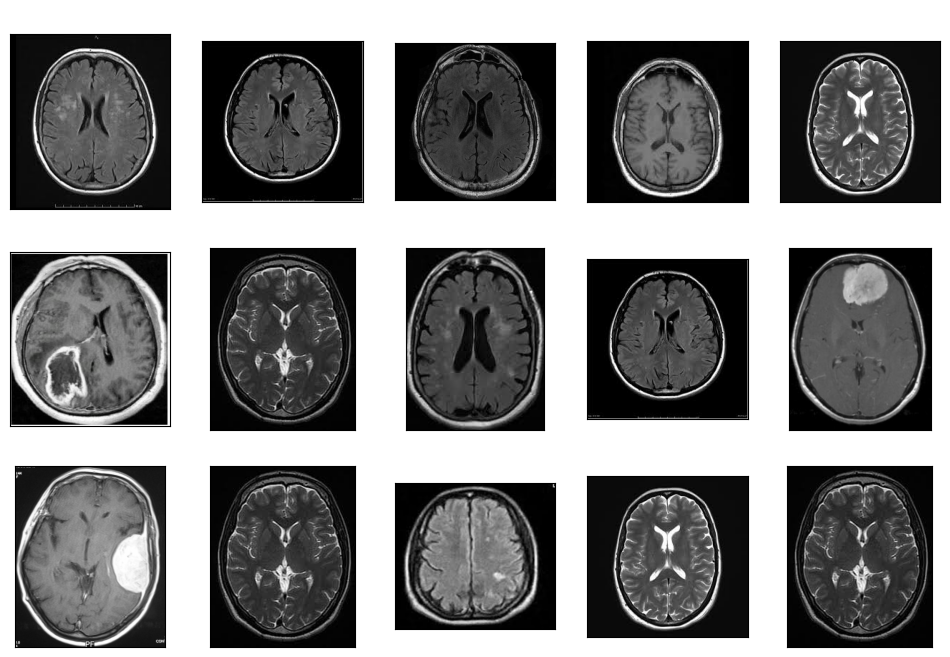

In [11]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (68, 2)
test set shape: (4, 2)
validation set shape: (8, 2)


In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [14]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 68 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
Found 4 validated image filenames belonging to 2 classes.


In [15]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [17]:

from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23564800 (89.89 MB)
________________

In [24]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 70, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/70
3/3 [==============================] - 6s 2s/step - loss: 0.4883 - accuracy: 0.7794 - val_loss: 0.2836 - val_accuracy: 0.8750


C:\Users\Priya\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/70
3/3 [==============================] - 3s 799ms/step - loss: 0.3770 - accuracy: 0.8529 - val_loss: 0.2658 - val_accuracy: 1.0000
Epoch 3/70
3/3 [==============================] - 3s 688ms/step - loss: 0.4419 - accuracy: 0.7647 - val_loss: 0.3775 - val_accuracy: 0.8750
Epoch 4/70
3/3 [==============================] - 3s 1s/step - loss: 0.4522 - accuracy: 0.8088 - val_loss: 0.3883 - val_accuracy: 0.7500
Epoch 5/70
3/3 [==============================] - 3s 1s/step - loss: 0.3763 - accuracy: 0.8676 - val_loss: 0.3436 - val_accuracy: 0.8750
Epoch 6/70
3/3 [==============================] - 3s 1s/step - loss: 0.4137 - accuracy: 0.8382 - val_loss: 0.5068 - val_accuracy: 0.6250
Epoch 7/70
3/3 [==============================] - 3s 689ms/step - loss: 0.4111 - accuracy: 0.8235 - val_loss: 0.4986 - val_accuracy: 0.7500
Epoch 8/70
3/3 [==============================] - 3s 1s/step - loss: 0.5000 - accuracy: 0.6618 - val_loss: 0.2812 - val_accuracy: 0.7500
Epoch 9/70
3/3 [================

Epoch 61/70
3/3 [==============================] - 3s 823ms/step - loss: 0.3102 - accuracy: 0.8971 - val_loss: 0.4900 - val_accuracy: 0.7500
Epoch 62/70
3/3 [==============================] - 3s 866ms/step - loss: 0.3952 - accuracy: 0.8529 - val_loss: 0.2590 - val_accuracy: 1.0000
Epoch 63/70
3/3 [==============================] - 3s 862ms/step - loss: 0.3212 - accuracy: 0.8676 - val_loss: 0.2204 - val_accuracy: 1.0000
Epoch 64/70
3/3 [==============================] - 3s 867ms/step - loss: 0.3837 - accuracy: 0.8088 - val_loss: 0.3008 - val_accuracy: 0.8750
Epoch 65/70
3/3 [==============================] - 3s 835ms/step - loss: 0.3869 - accuracy: 0.8235 - val_loss: 0.3341 - val_accuracy: 0.8750
Epoch 66/70
3/3 [==============================] - 3s 2s/step - loss: 0.3848 - accuracy: 0.8529 - val_loss: 0.3050 - val_accuracy: 0.8750
Epoch 67/70
3/3 [==============================] - 3s 829ms/step - loss: 0.3182 - accuracy: 0.8824 - val_loss: 0.2080 - val_accuracy: 1.0000
Epoch 68/70
3/3 

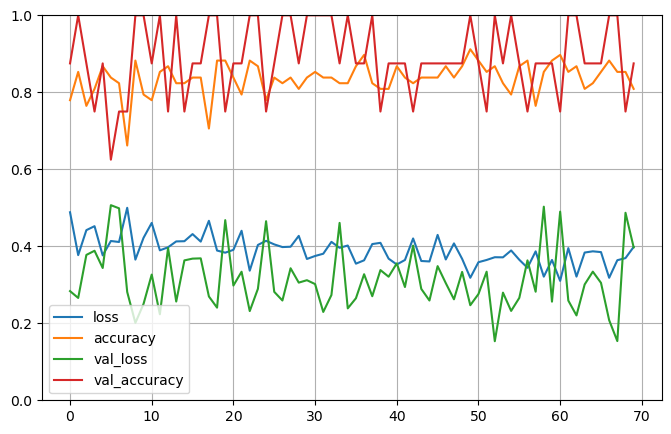

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()